In [2]:
import kagglehub
kazanova_sentiment140_path = kagglehub.dataset_download('kazanova/sentiment140')
print(kazanova_sentiment140_path)
print('Data source import complete.')


/opt/anaconda3/envs/paml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/yihanzhou/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2
Data source import complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

from sklearn.utils import resample  

from sklearn.model_selection import train_test_split    
from sklearn.metrics import (accuracy_score, precision_score,        
                             recall_score, f1_score,
                             confusion_matrix, classification_report)

from sklearn.feature_extraction.text import TfidfVectorizer           

from tensorflow.keras.preprocessing.text import Tokenizer             
from tensorflow.keras.preprocessing.sequence import pad_sequences      


# EDA

In this data preparation phase, we import the Sentiment140 dataset and configure appropriate column headers to facilitate analysis. To optimize computational efficiency while preserving statistical significance, we extract a balanced random sample of 1,000,000 tweets from the full corpus. We conduct exploratory data analysis to examine the dataset's structural characteristics, particularly focusing on sentiment class distribution to ensure representativeness. The final step involves partitioning the data into stratified training and testing sets using an 80:20 ratio, which maintains proportional representation of positive and negative sentiment classes in both subsets, thus providing a robust foundation for model development and evaluation.


   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------

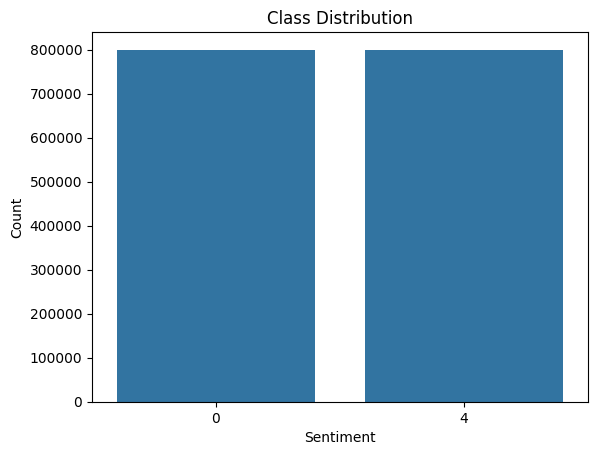

In [4]:
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', header=None)

df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

print(df.head())

print(df.info())

print(df['target'].value_counts())

sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


train_df, test_df = train_test_split(
    df,
    test_size=200000,
    random_state=42,
    stratify=df['target']
)


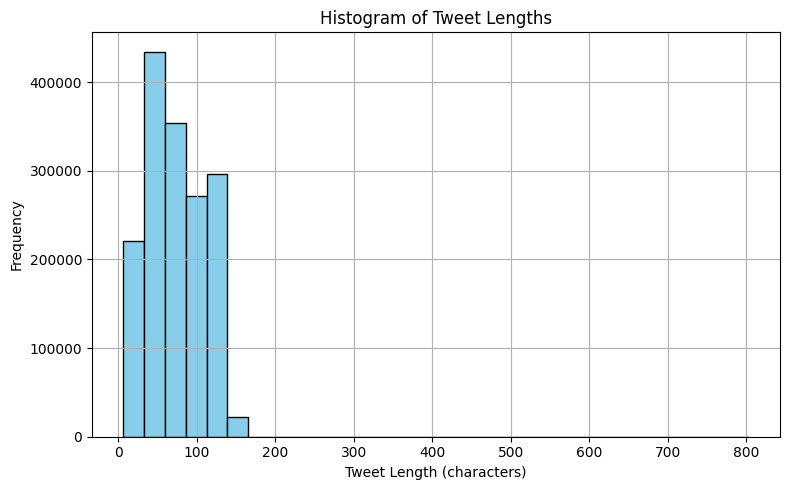

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df['length'] = df['text'].apply(len)

plt.figure(figsize=(8, 5))
plt.hist(df['length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Tweet Lengths')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


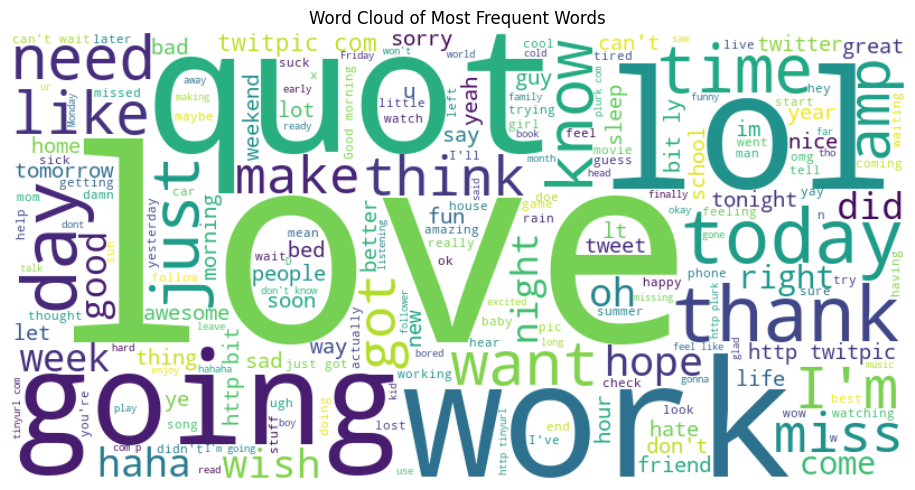

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

text_corpus = ' '.join(df['text'])

# generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=ENGLISH_STOP_WORDS).generate(text_corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.tight_layout()
plt.show()


# Feature Engineering

In this step, we perform basic text cleaning to prepare the tweets for modeling. We remove all irrelevant columns: URLs, mentions, hashtags, punctuation, and convert all text to lowercase. We also download the required NLTK resources such as stopwords and tokenizers. After cleaning, we apply the function to both training and testing datasets. Finally, we check the class distribution to identify any imbalance.


In [5]:

import nltk
nltk.download('stopwords')
nltk.download('punkt') 

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)        # Remove user mentions
    text = re.sub(r'#', '', text)           # Remove hashtag symbol but keep the word
    text = re.sub(r'[^\w\s]', '', text)     # Remove punctuation
    text = text.lower()                     # Convert text to lowercase
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print(train_df['target'].value_counts())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yihanzhou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yihanzhou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


target
0    700000
4    700000
Name: count, dtype: int64


# Tokenization and Padding

We tokenize cleaned tweets using Keras' Tokenizer, fitting it exclusively on training data to prevent data leakage. The tokenizer converts words to integer indices, transforming text into numerical sequences. We then standardize input dimensions by padding all sequences to a uniform length, ensuring compatibility with neural network architecture requirements. Finally, we normalize the sentiment labels from their original values (0 and 4) to binary format (0 and 1) for classification purposes.

In [6]:

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") 
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

max_len = 300
X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y_train = train_df['target'].replace({4: 1})
y_test = test_df['target'].replace({4: 1})


## Baseline model: Logistic Regression (From Scratch with Averaged Embeddings)

As our baseline, we implement Logistic Regression from scratch using NumPy. However, directly using padded integer sequences as input features for Logistic Regression is problematic due to the lack of meaningful numerical relationships between token indices and potential numerical instability.

A better approach, aligning with our proposal's mention of using embeddings, is to first convert the integer sequences into dense word embedding vectors and then aggregate these vectors into a single feature vector for each tweet. We will use the average of the word embeddings in a tweet as its feature representation. This captures semantic information more effectively than raw indices and provides a more suitable input for Logistic Regression.

First, we need to obtain the embedding vectors for our sequences. We can use a Keras `Embedding` layer for this. Then, we'll average these embeddings for each tweet.

In [8]:
import numpy as np
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import gc

embedding_dim = 128
vocab_size = 10000 
max_len = 500 
batch_size = 4096*2

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len,
                            mask_zero=True)
temp_model = Sequential([embedding_layer])
temp_model.build(input_shape=(None, max_len))

def masked_mean(embeddings, mask):
    mask = np.expand_dims(mask.astype(np.float32), axis=-1)
    
    masked_embeddings = embeddings * mask

    sum_embeddings = np.sum(masked_embeddings, axis=1)

    sum_mask = np.sum(mask, axis=1)
    
    sum_mask = np.maximum(sum_mask, 1e-9)
    
    return sum_embeddings / sum_mask


def generate_averaged_embeddings_batched(X_padded, batch_size, model, max_len):


    num_samples = X_padded.shape[0]
    averaged_embeddings_list = [] 
    
    print(f"Processing {num_samples} samples in batches of {batch_size}...")

    num_batches = (num_samples + batch_size - 1) // batch_size 
    
    for i in range(0, num_samples, batch_size):
        batch_start = i
        batch_end = min(i + batch_size, num_samples)
        X_batch = X_padded[batch_start:batch_end]


        embed_batch = model.predict(X_batch, batch_size=batch_size, verbose=0)
        
        mask_batch = (X_batch != 0)

        avg_embed_batch = masked_mean(embed_batch, mask_batch)

        averaged_embeddings_list.append(avg_embed_batch)

        del X_batch, embed_batch, mask_batch, avg_embed_batch
        gc.collect()

        current_batch_num = (i // batch_size) + 1
        if current_batch_num % 50 == 0 or current_batch_num == num_batches: 
            
             print(f"  Processed batch {current_batch_num} / {num_batches}")

    print("Batch processing complete. Concatenating results...")
    averaged_embeddings = np.concatenate(averaged_embeddings_list, axis=0)
    print("Concatenation complete.")
    return averaged_embeddings

print("Generating averaged embeddings for Training set...")
X_train_embed_avg = generate_averaged_embeddings_batched(X_train, batch_size, temp_model, max_len)

print("\nGenerating averaged embeddings for Test set...")
X_test_embed_avg = generate_averaged_embeddings_batched(X_test, batch_size, temp_model, max_len)

print("\nShape of final X_train_embed_avg:", X_train_embed_avg.shape)
print("Shape of final X_test_embed_avg:", X_test_embed_avg.shape)  

print("\nScaling features...")
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_embed_avg)

X_test_scaled = scaler.transform(X_test_embed_avg)

print("Scaled training data shape:", X_train_scaled.shape)
print("Scaled testing data shape:", X_test_scaled.shape)


print("\nCleaning up intermediate variables...")
del X_train_embed_avg, X_test_embed_avg
gc.collect()

print("Feature generation and scaling complete.")

/opt/anaconda3/envs/paml_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Generating averaged embeddings for Training set...
Processing 1400000 samples in batches of 8192...
  Processed batch 50 / 171
  Processed batch 100 / 171
  Processed batch 150 / 171
  Processed batch 171 / 171
Batch processing complete. Concatenating results...
Concatenation complete.

Generating averaged embeddings for Test set...
Processing 200000 samples in batches of 8192...
  Processed batch 25 / 25
Batch processing complete. Concatenating results...
Concatenation complete.

Shape of final X_train_embed_avg: (1400000, 128)
Shape of final X_test_embed_avg: (200000, 128)

Scaling features...
Scaled training data shape: (1400000, 128)
Scaled testing data shape: (200000, 128)

Cleaning up intermediate variables...
Feature generation and scaling complete.


Now, we define our Logistic Regression class implemented from scratch. This class encapsulates the sigmoid function, prediction logic, gradient calculation, weight updates (using gradient ascent), and the fitting process. We include options for L2 regularization and track the cost history. Using a class structure makes the code cleaner and reusable.

In [9]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=1000, reg_lambda=0.01, verbose_step=100):


        self.learning_rate = learning_rate
        self.epochs = epochs
        self.reg_lambda = reg_lambda
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.verbose_step = verbose_step

    def _sigmoid(self, z):
        
        z_clipped = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z_clipped))

    def _compute_cost(self, X, y):
        
        m = X.shape[0]
        z = X.dot(self.weights) + self.bias
        h = self._sigmoid(z)


        epsilon = 1e-15
        cost = -(1/m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))


        if self.reg_lambda > 0:
            l2_term = (self.reg_lambda / (2 * m)) * np.sum(np.square(self.weights))
            cost += l2_term

        return cost

    def fit(self, X, y):
        
        num_samples, num_features = X.shape


        self.weights = np.zeros(num_features)
        self.bias = 0
        self.cost_history = []


        for i in range(self.epochs):
            
            z = X.dot(self.weights) + self.bias
            h = self._sigmoid(z)


            dw = (1 / num_samples) * X.T.dot(h - y)
            db = (1 / num_samples) * np.sum(h - y)


            if self.reg_lambda > 0:
                dw += (self.reg_lambda / num_samples) * self.weights


            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


            cost = self._compute_cost(X, y)
            self.cost_history.append(cost)


            if self.verbose_step > 0 and (i + 1) % self.verbose_step == 0:
                print(f"Epoch {i+1}/{self.epochs}, Cost: {cost:.6f}")

    def predict_proba(self, X):
        
        z = X.dot(self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

Finally, we instantiate our `LogisticRegressionScratch` class, train it on the scaled averaged embedding features, and evaluate its performance on the test set using standard classification metrics. We also visualize the confusion matrix and the cost decrease during training.

Training Logistic Regression (from scratch) on averaged embeddings...
Epoch 100/500, Cost: 0.666028
Epoch 200/500, Cost: 0.656052
Epoch 300/500, Cost: 0.650367
Epoch 400/500, Cost: 0.646629
Epoch 500/500, Cost: 0.644010

Making predictions...

Baseline Model (Logistic Regression from Scratch w/ Avg Embeddings) Evaluation:
Accuracy:  0.6337
Precision: 0.6345
Recall:    0.6307
F1-Score:  0.6326


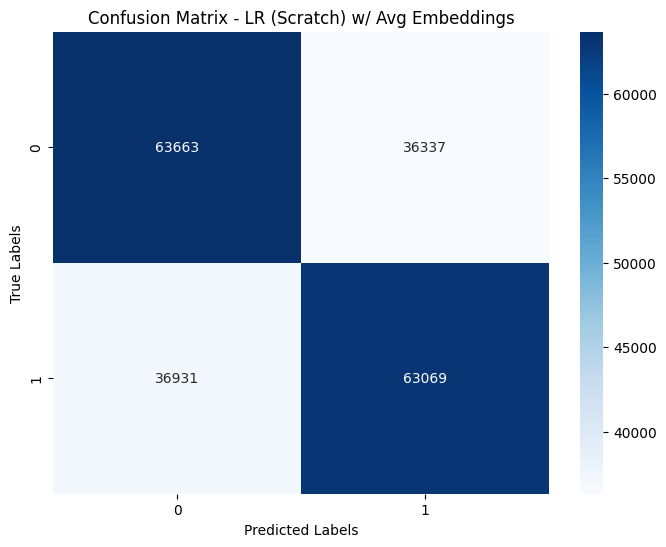

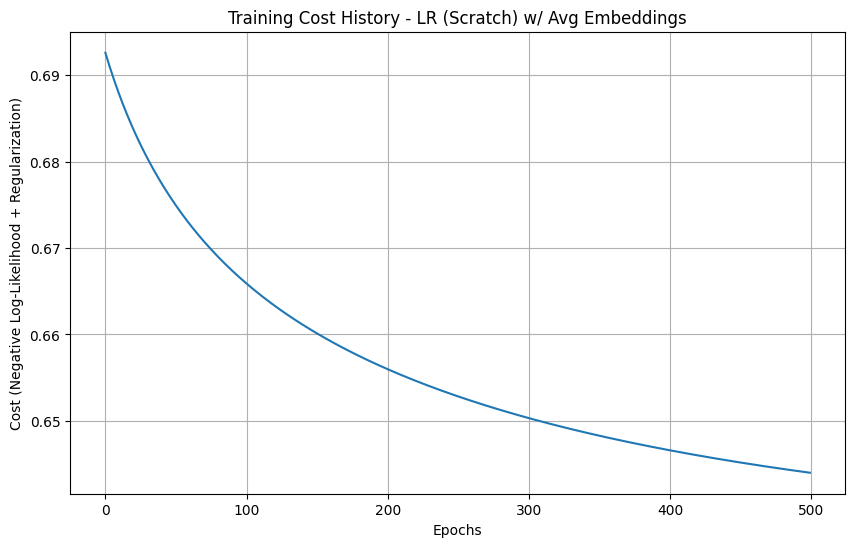

In [10]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_train_np = np.array(y_train)
y_test_np = np.array(y_test)



learning_rate = 0.01
epochs = 500     
reg_lambda = 0.1  
verbose_step = 100


baseline_model_embed = LogisticRegressionScratch(learning_rate=learning_rate,
                                                epochs=epochs,
                                                reg_lambda=reg_lambda,
                                                verbose_step=verbose_step)

print("Training Logistic Regression (from scratch) on averaged embeddings...")
baseline_model_embed.fit(X_train_scaled, y_train_np)


print("\nMaking predictions...")
y_pred_embed = baseline_model_embed.predict(X_test_scaled)


print("\nBaseline Model (Logistic Regression from Scratch w/ Avg Embeddings) Evaluation:")

accuracy = accuracy_score(y_test_np, y_pred_embed)

precision = precision_score(y_test_np, y_pred_embed, zero_division=0)
recall = recall_score(y_test_np, y_pred_embed, zero_division=0)
f1 = f1_score(y_test_np, y_pred_embed, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test_np, y_pred_embed)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LR (Scratch) w/ Avg Embeddings')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(baseline_model_embed.cost_history)
plt.title('Training Cost History - LR (Scratch) w/ Avg Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Cost (Negative Log-Likelihood + Regularization)')
plt.grid(True)
plt.show()

## Logistic Regression with TF-IDF Features
#Best
#so
#far
Instead of sequences, we use TF-IDF to represent the text, capturing word importance based on frequency. This method often works well with classical models like Logistic Regression. We then train and evaluate the model to compare its performance with the sequence-based approach. Due to computational constraints, we limit the size of dataset to 20000. We also visualize the confusion matrix and classification report to assess the model's performance.

Converting text to TF-IDF features...
Data split for training and validation complete.

--- Training with lr=0.01, lambda=0.0 ---
Starting training for 30 epochs, batch_size=1024, lr=0.01, lambda=0.0


  [Epoch 1] Processed batch 1/1094
  [Epoch 1] Processed batch 11/1094
  [Epoch 1] Processed batch 21/1094
  [Epoch 1] Processed batch 31/1094
  [Epoch 1] Processed batch 41/1094
  [Epoch 1] Processed batch 51/1094
  [Epoch 1] Processed batch 61/1094
  [Epoch 1] Processed batch 71/1094
  [Epoch 1] Processed batch 81/1094
  [Epoch 1] Processed batch 91/1094
  [Epoch 1] Processed batch 101/1094
  [Epoch 1] Processed batch 111/1094
  [Epoch 1] Processed batch 121/1094
  [Epoch 1] Processed batch 131/1094
  [Epoch 1] Processed batch 141/1094
  [Epoch 1] Processed batch 151/1094
  [Epoch 1] Processed batch 161/1094
  [Epoch 1] Processed batch 171/1094
  [Epoch 1] Processed batch 181/1094
  [Epoch 1] Processed batch 191/1094
  [Epoch 1] Processed batch 201/1094
  [Epoch 1] Processed batch 211/1094
  [Epoch 1] Processed batch 221/1094
  [Epoch 1] Processed batch 231/1094
  [Epoch 1] Processed batch 241/1094
  [Epoch 1] Processed batch 251/1094
  [Epoch 1] Processed batch 261/1094
  [Epoch 1] 

  [Epoch 1] Processed batch 971/1094
  [Epoch 1] Processed batch 981/1094
  [Epoch 1] Processed batch 991/1094
  [Epoch 1] Processed batch 1001/1094
  [Epoch 1] Processed batch 1011/1094
  [Epoch 1] Processed batch 1021/1094
  [Epoch 1] Processed batch 1031/1094
  [Epoch 1] Processed batch 1041/1094
  [Epoch 1] Processed batch 1051/1094
  [Epoch 1] Processed batch 1061/1094
  [Epoch 1] Processed batch 1071/1094
  [Epoch 1] Processed batch 1081/1094
  [Epoch 1] Processed batch 1091/1094
  [Epoch 1] Processed batch 1094/1094
Epoch   1/30 - Log Likelihood: -0.6905


Epoch   6/30 - Log Likelihood: -0.6782


Epoch  11/30 - Log Likelihood: -0.6675


Epoch  16/30 - Log Likelihood: -0.6580


Epoch  21/30 - Log Likelihood: -0.6497


Epoch  26/30 - Log Likelihood: -0.6423






Epochs: 100%|██████████| 30/30 [00:06<00:00,  4.41it/s]


Epoch  30/30 - Log Likelihood: -0.6370
Training complete!
Validation accuracy for lr=0.01, lambda=0.0: 0.7157

--- Training with lr=0.01, lambda=0.01 ---
Starting training for 30 epochs, batch_size=1024, lr=0.01, lambda=0.01


  [Epoch 1] Processed batch 1/1094
  [Epoch 1] Processed batch 11/1094
  [Epoch 1] Processed batch 21/1094
  [Epoch 1] Processed batch 31/1094
  [Epoch 1] Processed batch 41/1094
  [Epoch 1] Processed batch 51/1094
  [Epoch 1] Processed batch 61/1094
  [Epoch 1] Processed batch 71/1094
  [Epoch 1] Processed batch 81/1094
  [Epoch 1] Processed batch 91/1094
  [Epoch 1] Processed batch 101/1094
  [Epoch 1] Processed batch 111/1094
  [Epoch 1] Processed batch 121/1094
  [Epoch 1] Processed batch 131/1094
  [Epoch 1] Processed batch 141/1094
  [Epoch 1] Processed batch 151/1094
  [Epoch 1] Processed batch 161/1094
  [Epoch 1] Processed batch 171/1094
  [Epoch 1] Processed batch 181/1094
  [Epoch 1] Processed batch 191/1094
  [Epoch 1] Processed batch 201/1094
  [Epoch 1] Processed batch 211/1094
  [Epoch 1] Processed batch 221/1094
  [Epoch 1] Processed batch 231/1094
  [Epoch 1] Processed batch 241/1094
  [Epoch 1] Processed batch 251/1094
  [Epoch 1] Processed batch 261/1094
  [Epoch 1] 

  [Epoch 1] Processed batch 1091/1094
  [Epoch 1] Processed batch 1094/1094
Epoch   1/30 - Log Likelihood: -0.6906


Epoch   6/30 - Log Likelihood: -0.6820


Epoch  11/30 - Log Likelihood: -0.6775


Epoch  16/30 - Log Likelihood: -0.6751


Epoch  21/30 - Log Likelihood: -0.6739


Epoch  26/30 - Log Likelihood: -0.6732






Epochs: 100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


Epoch  30/30 - Log Likelihood: -0.6729
Training complete!
Validation accuracy for lr=0.01, lambda=0.01: 0.7122

--- Training with lr=0.01, lambda=0.1 ---
Starting training for 30 epochs, batch_size=1024, lr=0.01, lambda=0.1


  [Epoch 1] Processed batch 1/1094
  [Epoch 1] Processed batch 11/1094
  [Epoch 1] Processed batch 21/1094
  [Epoch 1] Processed batch 31/1094
  [Epoch 1] Processed batch 41/1094
  [Epoch 1] Processed batch 51/1094
  [Epoch 1] Processed batch 61/1094
  [Epoch 1] Processed batch 71/1094
  [Epoch 1] Processed batch 81/1094
  [Epoch 1] Processed batch 91/1094
  [Epoch 1] Processed batch 101/1094
  [Epoch 1] Processed batch 111/1094
  [Epoch 1] Processed batch 121/1094
  [Epoch 1] Processed batch 131/1094
  [Epoch 1] Processed batch 141/1094
  [Epoch 1] Processed batch 151/1094
  [Epoch 1] Processed batch 161/1094
  [Epoch 1] Processed batch 171/1094
  [Epoch 1] Processed batch 181/1094
  [Epoch 1] Processed batch 191/1094
  [Epoch 1] Processed batch 201/1094
  [Epoch 1] Processed batch 211/1094
  [Epoch 1] Processed batch 221/1094
  [Epoch 1] Processed batch 231/1094
  [Epoch 1] Processed batch 241/1094
  [Epoch 1] Processed batch 251/1094
  [Epoch 1] Processed batch 261/1094
  [Epoch 1] 

  [Epoch 1] Processed batch 961/1094
  [Epoch 1] Processed batch 971/1094
  [Epoch 1] Processed batch 981/1094
  [Epoch 1] Processed batch 991/1094
  [Epoch 1] Processed batch 1001/1094
  [Epoch 1] Processed batch 1011/1094
  [Epoch 1] Processed batch 1021/1094
  [Epoch 1] Processed batch 1031/1094
  [Epoch 1] Processed batch 1041/1094
  [Epoch 1] Processed batch 1051/1094
  [Epoch 1] Processed batch 1061/1094
  [Epoch 1] Processed batch 1071/1094
  [Epoch 1] Processed batch 1081/1094
  [Epoch 1] Processed batch 1091/1094
  [Epoch 1] Processed batch 1094/1094
Epoch   1/30 - Log Likelihood: -0.6915


Epoch   6/30 - Log Likelihood: -0.6907


Epoch  11/30 - Log Likelihood: -0.6907


Epoch  16/30 - Log Likelihood: -0.6907


Epoch  21/30 - Log Likelihood: -0.6907


Epoch  26/30 - Log Likelihood: -0.6907






Epochs: 100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Epoch  30/30 - Log Likelihood: -0.6907
Training complete!
Validation accuracy for lr=0.01, lambda=0.1: 0.7038

--- Training with lr=0.001, lambda=0.0 ---
Starting training for 30 epochs, batch_size=1024, lr=0.001, lambda=0.0


  [Epoch 1] Processed batch 1/1094
  [Epoch 1] Processed batch 11/1094
  [Epoch 1] Processed batch 21/1094
  [Epoch 1] Processed batch 31/1094
  [Epoch 1] Processed batch 41/1094
  [Epoch 1] Processed batch 51/1094
  [Epoch 1] Processed batch 61/1094
  [Epoch 1] Processed batch 71/1094
  [Epoch 1] Processed batch 81/1094
  [Epoch 1] Processed batch 91/1094
  [Epoch 1] Processed batch 101/1094
  [Epoch 1] Processed batch 111/1094
  [Epoch 1] Processed batch 121/1094
  [Epoch 1] Processed batch 131/1094
  [Epoch 1] Processed batch 141/1094
  [Epoch 1] Processed batch 151/1094
  [Epoch 1] Processed batch 161/1094
  [Epoch 1] Processed batch 171/1094
  [Epoch 1] Processed batch 181/1094
  [Epoch 1] Processed batch 191/1094
  [Epoch 1] Processed batch 201/1094
  [Epoch 1] Processed batch 211/1094
  [Epoch 1] Processed batch 221/1094
  [Epoch 1] Processed batch 231/1094
  [Epoch 1] Processed batch 241/1094
  [Epoch 1] Processed batch 251/1094
  [Epoch 1] Processed batch 261/1094
  [Epoch 1] 

  [Epoch 1] Processed batch 941/1094
  [Epoch 1] Processed batch 951/1094
  [Epoch 1] Processed batch 961/1094
  [Epoch 1] Processed batch 971/1094
  [Epoch 1] Processed batch 981/1094
  [Epoch 1] Processed batch 991/1094
  [Epoch 1] Processed batch 1001/1094
  [Epoch 1] Processed batch 1011/1094
  [Epoch 1] Processed batch 1021/1094
  [Epoch 1] Processed batch 1031/1094
  [Epoch 1] Processed batch 1041/1094
  [Epoch 1] Processed batch 1051/1094
  [Epoch 1] Processed batch 1061/1094
  [Epoch 1] Processed batch 1071/1094
  [Epoch 1] Processed batch 1081/1094
  [Epoch 1] Processed batch 1091/1094
  [Epoch 1] Processed batch 1094/1094
Epoch   1/30 - Log Likelihood: -0.6929


Epoch   6/30 - Log Likelihood: -0.6915


Epoch  11/30 - Log Likelihood: -0.6902


Epoch  16/30 - Log Likelihood: -0.6889


Epoch  21/30 - Log Likelihood: -0.6876








Epochs:  90%|█████████ | 27/30 [00:05<00:00,  4.97it/s]

Epoch  26/30 - Log Likelihood: -0.6864





Epochs: 100%|██████████| 30/30 [00:06<00:00,  4.73it/s]


Epoch  30/30 - Log Likelihood: -0.6853
Training complete!
Validation accuracy for lr=0.001, lambda=0.0: 0.7102

--- Training with lr=0.001, lambda=0.01 ---
Starting training for 30 epochs, batch_size=1024, lr=0.001, lambda=0.01


  [Epoch 1] Processed batch 1/1094
  [Epoch 1] Processed batch 11/1094
  [Epoch 1] Processed batch 21/1094
  [Epoch 1] Processed batch 31/1094
  [Epoch 1] Processed batch 41/1094
  [Epoch 1] Processed batch 51/1094
  [Epoch 1] Processed batch 61/1094
  [Epoch 1] Processed batch 71/1094
  [Epoch 1] Processed batch 81/1094
  [Epoch 1] Processed batch 91/1094
  [Epoch 1] Processed batch 101/1094
  [Epoch 1] Processed batch 111/1094
  [Epoch 1] Processed batch 121/1094
  [Epoch 1] Processed batch 131/1094
  [Epoch 1] Processed batch 141/1094
  [Epoch 1] Processed batch 151/1094
  [Epoch 1] Processed batch 161/1094
  [Epoch 1] Processed batch 171/1094
  [Epoch 1] Processed batch 181/1094
  [Epoch 1] Processed batch 191/1094
  [Epoch 1] Processed batch 201/1094
  [Epoch 1] Processed batch 211/1094
  [Epoch 1] Processed batch 221/1094
  [Epoch 1] Processed batch 231/1094
  [Epoch 1] Processed batch 241/1094
  [Epoch 1] Processed batch 251/1094
  [Epoch 1] Processed batch 261/1094
  [Epoch 1] 

  [Epoch 1] Processed batch 981/1094
  [Epoch 1] Processed batch 991/1094
  [Epoch 1] Processed batch 1001/1094
  [Epoch 1] Processed batch 1011/1094
  [Epoch 1] Processed batch 1021/1094
  [Epoch 1] Processed batch 1031/1094
  [Epoch 1] Processed batch 1041/1094
  [Epoch 1] Processed batch 1051/1094
  [Epoch 1] Processed batch 1061/1094
  [Epoch 1] Processed batch 1071/1094
  [Epoch 1] Processed batch 1081/1094
  [Epoch 1] Processed batch 1091/1094
  [Epoch 1] Processed batch 1094/1094
Epoch   1/30 - Log Likelihood: -0.6929


Epoch   6/30 - Log Likelihood: -0.6916


Epoch  11/30 - Log Likelihood: -0.6904


Epoch  16/30 - Log Likelihood: -0.6893


Epoch  21/30 - Log Likelihood: -0.6882


Epoch  26/30 - Log Likelihood: -0.6872





Epochs: 100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


Epoch  30/30 - Log Likelihood: -0.6865
Training complete!
Validation accuracy for lr=0.001, lambda=0.01: 0.7102

--- Training with lr=0.001, lambda=0.1 ---
Starting training for 30 epochs, batch_size=1024, lr=0.001, lambda=0.1


  [Epoch 1] Processed batch 1/1094
  [Epoch 1] Processed batch 11/1094
  [Epoch 1] Processed batch 21/1094
  [Epoch 1] Processed batch 31/1094
  [Epoch 1] Processed batch 41/1094
  [Epoch 1] Processed batch 51/1094
  [Epoch 1] Processed batch 61/1094
  [Epoch 1] Processed batch 71/1094
  [Epoch 1] Processed batch 81/1094
  [Epoch 1] Processed batch 91/1094
  [Epoch 1] Processed batch 101/1094
  [Epoch 1] Processed batch 111/1094
  [Epoch 1] Processed batch 121/1094
  [Epoch 1] Processed batch 131/1094
  [Epoch 1] Processed batch 141/1094
  [Epoch 1] Processed batch 151/1094
  [Epoch 1] Processed batch 161/1094
  [Epoch 1] Processed batch 171/1094
  [Epoch 1] Processed batch 181/1094
  [Epoch 1] Processed batch 191/1094
  [Epoch 1] Processed batch 201/1094
  [Epoch 1] Processed batch 211/1094
  [Epoch 1] Processed batch 221/1094
  [Epoch 1] Processed batch 231/1094
  [Epoch 1] Processed batch 241/1094
  [Epoch 1] Processed batch 251/1094
  [Epoch 1] Processed batch 261/1094
  [Epoch 1] 

Epoch   1/30 - Log Likelihood: -0.6929


Epoch   6/30 - Log Likelihood: -0.6920


Epoch  11/30 - Log Likelihood: -0.6914


Epoch  16/30 - Log Likelihood: -0.6911


Epoch  21/30 - Log Likelihood: -0.6910


Epoch  26/30 - Log Likelihood: -0.6909






Epochs: 100%|██████████| 30/30 [00:06<00:00,  4.44it/s]


Epoch  30/30 - Log Likelihood: -0.6908
Training complete!
Validation accuracy for lr=0.001, lambda=0.1: 0.7099

Best config found: lr=0.01, lambda=0.0 with val_acc=0.7157

Retraining on the full training set with the best config...
Starting training for 30 epochs, batch_size=1024, lr=0.01, lambda=0.0


  [Epoch 1] Processed batch 1/1368
  [Epoch 1] Processed batch 11/1368
  [Epoch 1] Processed batch 21/1368
  [Epoch 1] Processed batch 31/1368
  [Epoch 1] Processed batch 41/1368
  [Epoch 1] Processed batch 51/1368
  [Epoch 1] Processed batch 61/1368
  [Epoch 1] Processed batch 71/1368
  [Epoch 1] Processed batch 81/1368
  [Epoch 1] Processed batch 91/1368
  [Epoch 1] Processed batch 101/1368
  [Epoch 1] Processed batch 111/1368
  [Epoch 1] Processed batch 121/1368
  [Epoch 1] Processed batch 131/1368
  [Epoch 1] Processed batch 141/1368
  [Epoch 1] Processed batch 151/1368
  [Epoch 1] Processed batch 161/1368
  [Epoch 1] Processed batch 171/1368
  [Epoch 1] Processed batch 181/1368
  [Epoch 1] Processed batch 191/1368
  [Epoch 1] Processed batch 201/1368
  [Epoch 1] Processed batch 211/1368
  [Epoch 1] Processed batch 221/1368
  [Epoch 1] Processed batch 231/1368
  [Epoch 1] Processed batch 241/1368
  [Epoch 1] Processed batch 251/1368
  [Epoch 1] Processed batch 261/1368
  [Epoch 1] 

  [Epoch 1] Processed batch 651/1368
  [Epoch 1] Processed batch 661/1368
  [Epoch 1] Processed batch 671/1368
  [Epoch 1] Processed batch 681/1368
  [Epoch 1] Processed batch 691/1368
  [Epoch 1] Processed batch 701/1368
  [Epoch 1] Processed batch 711/1368
  [Epoch 1] Processed batch 721/1368
  [Epoch 1] Processed batch 731/1368
  [Epoch 1] Processed batch 741/1368
  [Epoch 1] Processed batch 751/1368
  [Epoch 1] Processed batch 761/1368
  [Epoch 1] Processed batch 771/1368
  [Epoch 1] Processed batch 781/1368
  [Epoch 1] Processed batch 791/1368
  [Epoch 1] Processed batch 801/1368
  [Epoch 1] Processed batch 811/1368
  [Epoch 1] Processed batch 821/1368
  [Epoch 1] Processed batch 831/1368
  [Epoch 1] Processed batch 841/1368
  [Epoch 1] Processed batch 851/1368
  [Epoch 1] Processed batch 861/1368
  [Epoch 1] Processed batch 871/1368
  [Epoch 1] Processed batch 881/1368
  [Epoch 1] Processed batch 891/1368
  [Epoch 1] Processed batch 901/1368
  [Epoch 1] Processed batch 911/1368
 

Epoch   6/30 - Log Likelihood: -0.6748


Epoch  11/30 - Log Likelihood: -0.6622


Epoch  16/30 - Log Likelihood: -0.6513


Epoch  21/30 - Log Likelihood: -0.6420


Epoch  26/30 - Log Likelihood: -0.6339






Epochs: 100%|██████████| 30/30 [00:08<00:00,  3.36it/s]

Epoch  30/30 - Log Likelihood: -0.6282
Training complete!
Making predictions on test set...

=== Model Evaluation Metrics ===
Accuracy:  0.7160
Precision: 0.7069
Recall:    0.7381
F1-Score:  0.7222


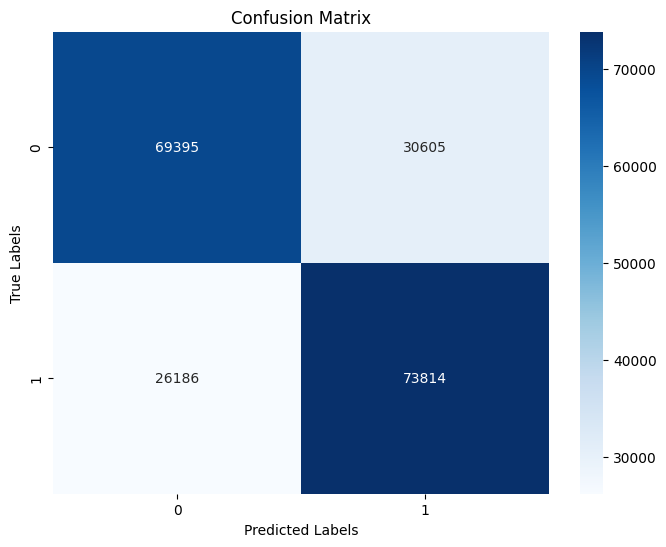

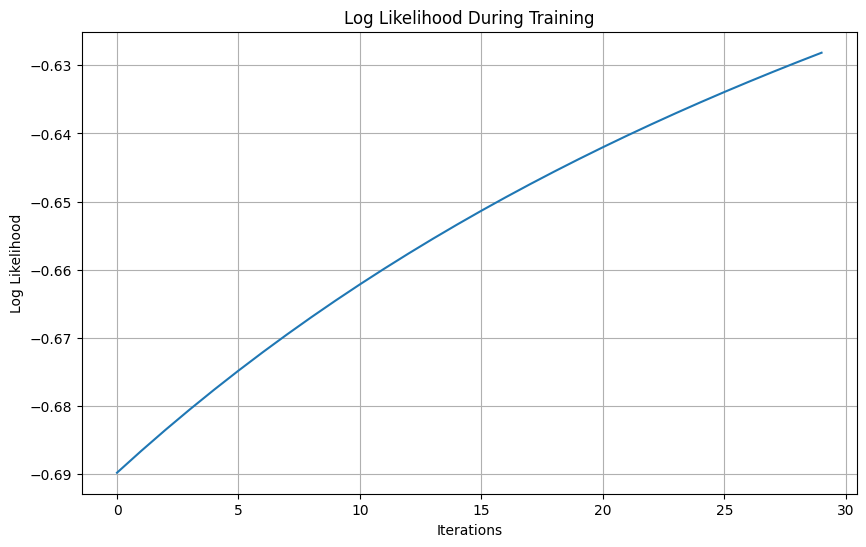

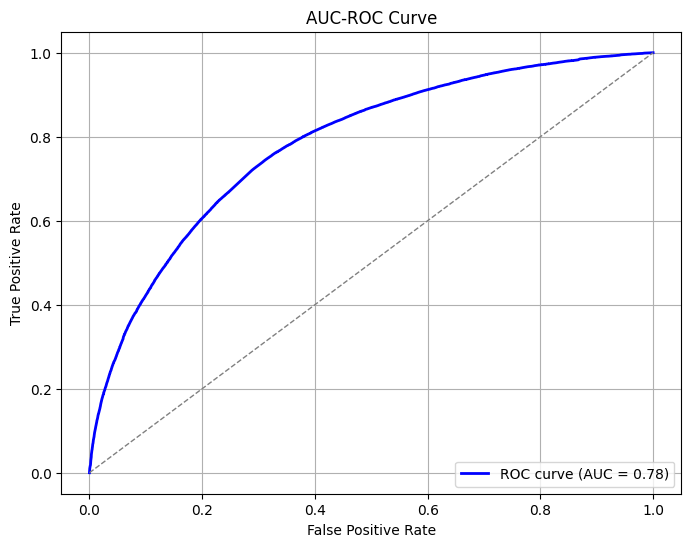

In [10]:
import numpy as np
from scipy.special import expit
from scipy.sparse import issparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def safe_sigmoid(x):
    return expit(x)

def compute_log_likelihood(X, Y, W):
    scores = X.dot(W)
    # Numerically stable log likelihood
    ll = np.sum(Y * scores - np.logaddexp(0, scores))
    return ll / X.shape[0]

def update_weights_batch(X_batch, Y_batch, W, b, learning_rate, reg_lambda):
    scores = X_batch.dot(W) + b
    y_pred = safe_sigmoid(scores)
    error = Y_batch - y_pred
    if issparse(X_batch):
        dW = X_batch.T.dot(error) / X_batch.shape[0] - reg_lambda * W
    else:
        dW = np.dot(X_batch.T, error) / X_batch.shape[0] - reg_lambda * W
    db = np.sum(error) / X_batch.shape[0]
    W_new = W + learning_rate * dW
    b_new = b + learning_rate * db
    return W_new, b_new

def fit(X, Y, num_iterations=100, learning_rate=1e-3, batch_size=1024, reg_lambda=0.0, verbose=True):
    num_examples, num_features = X.shape
    W = np.zeros(num_features)
    b = 0
    likelihood_history = []

    print(f"Starting training for {num_iterations} epochs, batch_size={batch_size}, lr={learning_rate}, lambda={reg_lambda}")
    for epoch in tqdm(range(num_iterations), desc="Epochs"):
        indices = np.arange(num_examples)
        np.random.shuffle(indices)
        X_shuffled = X[indices] if not issparse(X) else X[indices, :]
        Y_shuffled = Y[indices]

        num_batches = int(np.ceil(num_examples / batch_size))
        for i, start in enumerate(range(0, num_examples, batch_size)):
            end = min(start + batch_size, num_examples)
            X_batch = X_shuffled[start:end]
            Y_batch = Y_shuffled[start:end]
            W, b = update_weights_batch(X_batch, Y_batch, W, b, learning_rate, reg_lambda)

            if verbose and epoch == 0 and (i % 10 == 0 or i == num_batches-1):
                print(f"  [Epoch 1] Processed batch {i+1}/{num_batches}")

        # Track log-likelihood
        ll = compute_log_likelihood(X, Y, W)
        likelihood_history.append(ll)
        # Print progress every 5 epochs
        if verbose and (epoch % 5 == 0 or epoch == num_iterations - 1):
            print(f"Epoch {epoch+1:3}/{num_iterations} - Log Likelihood: {ll:.4f}")

    print("Training complete!")
    return W, b, likelihood_history

def predict(X, W, b):
    scores = X.dot(W) + b
    probs = safe_sigmoid(scores)
    return (probs >= 0.5).astype(int)

def predict_proba(X, W, b):
    scores = X.dot(W) + b
    return safe_sigmoid(scores)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', min_df=5)
print("Converting text to TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Validation split
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42
)
print("Data split for training and validation complete.")

# Grid search for best lr/lambda
best_val_acc = 0
best_config = None
best_W, best_b = None, None

for lr in [0.01, 0.001]:
    for lam in [0.0, 0.01, 0.1]:
        print(f"\n--- Training with lr={lr}, lambda={lam} ---")
        W, b, _ = fit(X_subtrain, y_subtrain, learning_rate=lr, reg_lambda=lam, num_iterations=30, batch_size=1024, verbose=True)
        val_preds = predict(X_val, W, b)
        acc = accuracy_score(y_val, val_preds)
        print(f"Validation accuracy for lr={lr}, lambda={lam}: {acc:.4f}")
        if acc > best_val_acc:
            best_val_acc = acc
            best_config = (lr, lam)
            best_W, best_b = W, b

print(f"\nBest config found: lr={best_config[0]}, lambda={best_config[1]} with val_acc={best_val_acc:.4f}")

# Retrain on all training data with best config
print("\nRetraining on the full training set with the best config...")
sentiment_model_weights, sentiment_model_bias, likelihood_history = fit(
    X_train_tfidf, y_train,
    learning_rate=best_config[0],
    reg_lambda=best_config[1],
    num_iterations=30,
    batch_size=1024,
    verbose=True
)

print("Making predictions on test set...")
y_pred = predict(X_test_tfidf, sentiment_model_weights, sentiment_model_bias)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\n=== Model Evaluation Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Plotting
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(likelihood_history)
plt.title('Log Likelihood During Training')
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.grid(True)
plt.show()

# --- Add ROC-AUC plot here ---
y_prob = predict_proba(X_test_tfidf, sentiment_model_weights, sentiment_model_bias)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Naive Bayes Classifier

In [23]:
class NaiveBayesClassifier:
    def fit(self, X, y, alpha=1.0):
        """
        X: numpy.ndarray, shape (n_samples, n_features)
        y: numpy.ndarray, shape (n_samples,)
        """
        self.classes = np.unique(y)
        self.class_priors = {}
        self.feature_probs = {}

        for cls in self.classes:
            X_cls = X[y == cls]
            #  P(y)
            self.class_priors[cls] = X_cls.shape[0] / X.shape[0]
            #  P(x_i|y) 
            smoothed = X_cls.sum(axis=0) + alpha
            total = smoothed.sum()
            self.feature_probs[cls] = smoothed / total
            
    def predict_log_proba(self, X):
        """
        Return log probabilities of each class.
        """
        log_probs = []
        for i in range(X.shape[0]):
            x = X[i].toarray().flatten() if hasattr(X[i], "toarray") else np.asarray(X[i]).flatten()

            class_log_probs = {}
            for cls in self.classes:
                log_prob = np.log(self.class_priors[cls])
                log_prob += np.sum(x * np.log(self.feature_probs[cls]))
                class_log_probs[cls] = log_prob
            log_probs.append(class_log_probs)
        return log_probs



    def predict(self, X):
        """
        Predict the class labels for the input samples.
        """
        log_probs = self.predict_log_proba(X)
        return np.array([max(lp, key=lp.get) for lp in log_probs])


alpha=0.1, accuracy=0.7287
alpha=0.5, accuracy=0.7287
alpha=1.0, accuracy=0.7288
alpha=2.0, accuracy=0.7288

Naive Bayes Model Evaluation Metrics:
Accuracy:  0.7288
Precision: 0.7385
Recall:    0.7083
F1-Score:  0.7231


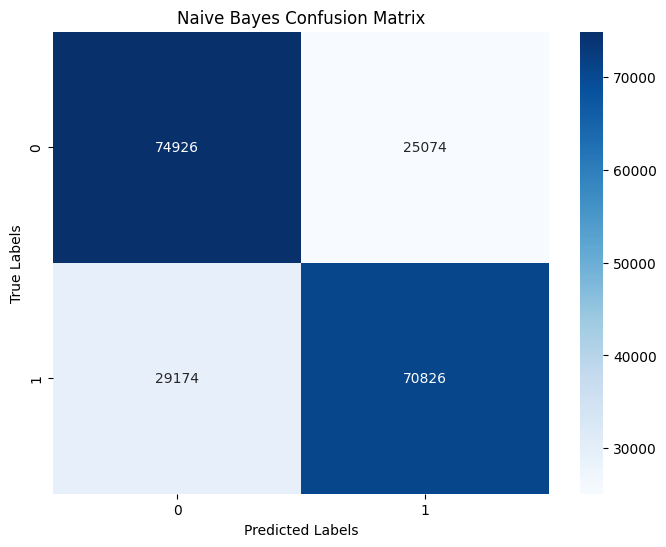

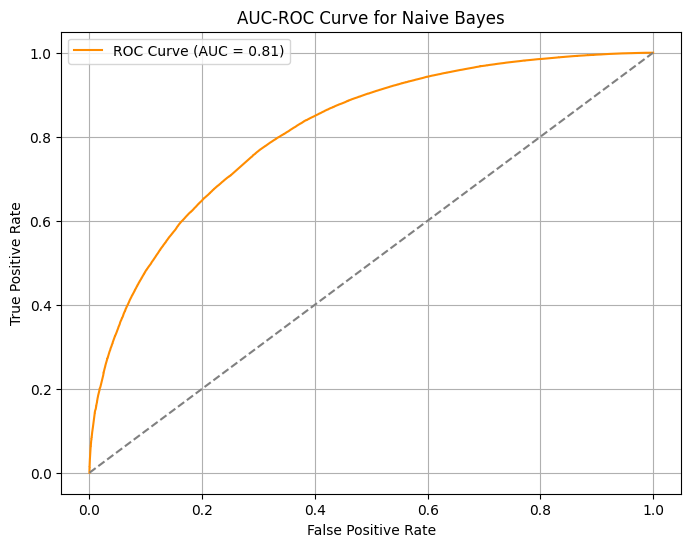

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

alphas = [0.1, 0.5, 1.0, 2.0]
best_alpha = None
best_model = None
best_score = 0

for alpha in alphas:
    nb = NaiveBayesClassifier()
    nb.fit(X_train_tfidf, y_train, alpha=alpha)
    y_pred_val = nb.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred_val)
    print(f"alpha={alpha}, accuracy={acc:.4f}")
    if acc > best_score:
        best_score = acc
        best_alpha = alpha
        best_model = nb

nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)
# y_pred = nb.predict(X_test)
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nNaive Bayes Model Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

log_probs = best_model.predict_log_proba(X_test_tfidf)
probs = [np.exp(lp[1]) / sum(np.exp(list(lp.values()))) for lp in log_probs] 

# AUC-ROC
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()


Naive Bayes with TF-IDF

In [15]:
print(df.columns)

Index(['target', 'ids', 'date', 'flag', 'user', 'text', 'length'], dtype='object')


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_texts = train_df['text'].values
test_texts = test_df['text'].values

# TF-IDF 
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(train_texts).toarray()
X_test_tfidf = vectorizer.transform(test_texts).toarray()



alpha=0.1, accuracy=0.7287
alpha=0.5, accuracy=0.7287
alpha=1.0, accuracy=0.7288
alpha=2.0, accuracy=0.7288

Naive Bayes Model Evaluation Metrics:
Best alpha: 2.0
Accuracy:  0.7288
Precision: 0.7385
Recall:    0.7083
F1-Score:  0.7231


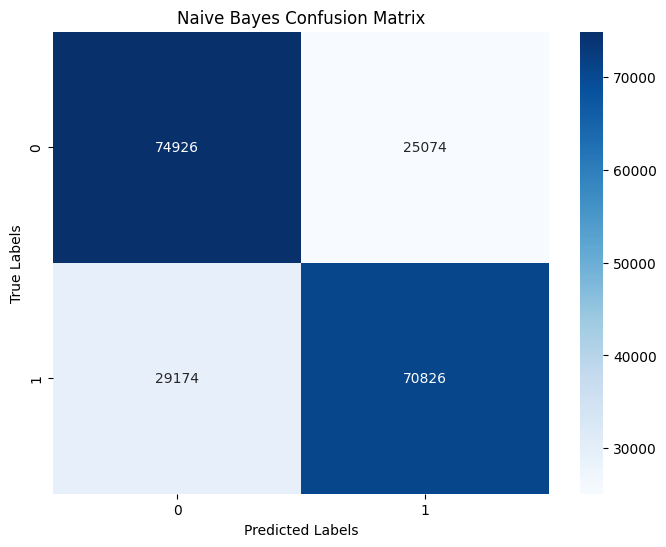

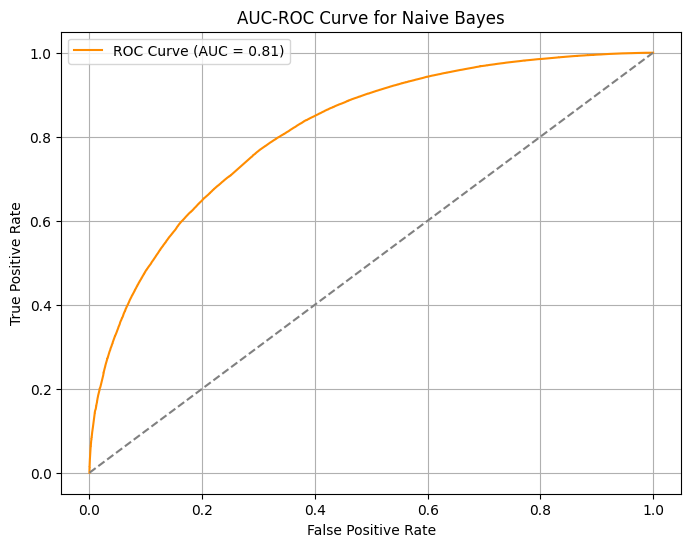

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# grid search：find best α
alphas = [0.1, 0.5, 1.0, 2.0]
best_alpha = None
best_model = None
best_score = 0

for alpha in alphas:
    nb = NaiveBayesClassifier()
    nb.fit(X_train_tfidf, y_train, alpha=alpha)
    y_pred_val = nb.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred_val)
    print(f"alpha={alpha}, accuracy={acc:.4f}")
    if acc > best_score:
        best_score = acc
        best_alpha = alpha
        best_model = nb

# train the best model
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nNaive Bayes Model Evaluation Metrics:")
print(f"Best alpha: {best_alpha}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# AUC-ROC
log_probs = best_model.predict_log_proba(X_test_tfidf)
probs = [np.exp(lp[1]) / sum(np.exp(list(lp.values()))) for lp in log_probs]

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()
